In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings("ignore")
# Load the df with the correct encoding
data = pd.read_csv('/kaggle/input/ventes-csv/ventes.csv', encoding='latin1')

# Display the first few rows of the dfset
data.head()


,Date,Heure,CODE_MAGASIN,Ticket,Code article,Libellé,Qté,PUTTC,REMISE_TAUX,PUTTC.net,Total TTC.net,% Tva,Type vente
0,01/10/2021,10:14:05,2,8,19101001.0,CO ETOILE AN,1.0,22.0,0.0,22.0,22.0,20.0,NaN
1,01/10/2021,10:16:15,2,9,1106145.0,BO OVALE TRESSE PO,1.0,46.0,0.0,46.0,46.0,20.0,NaN
2,01/10/2021,10:16:15,2,9,1106145.0,BO OVALE TRESSE PO,1.0,46.0,0.0,46.0,46.0,20.0,NaN
3,01/10/2021,10:55:56,2,10,25112143.0,CR1 CHAINE 2 TROUS AD,1.0,12.0,0.0,12.0,12.0,20.0,NaN
4,01/10/2021,11:07:56,2,11,25112139.0,CR TORSADE PIERRE TCL AD,1.0,18.0,0.0,18.0,18.0,20.0,NaN


In [2]:
# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

# Handle rows where date parsing failed
data = data.dropna(subset=['Date'])
data = data[data['Type vente'] != 'RETOUR']
# Create a new column for year and month
data['YearMonth'] = data['Date'].dt.to_period('M')

# Aggregate monthly sales by store
monthly_sales_store = data.groupby(['YearMonth', 'CODE_MAGASIN']).agg({'Total TTC.net': 'sum'}).reset_index()

# Convert the YearMonth column back to datetime for plotting
monthly_sales_store['YearMonth'] = monthly_sales_store['YearMonth'].dt.to_timestamp()

# Display the first few rows of the aggregated data
monthly_sales_store.head()

,YearMonth,CODE_MAGASIN,Total TTC.net
0,2021-10-01,2,63785.3
1,2021-10-01,3,17405.9
2,2021-11-01,2,56995.9
3,2021-11-01,3,14269.7
4,2021-12-01,2,171867.8


In [3]:
monthly_sales_store['YearMonth']=pd.to_datetime(monthly_sales_store['YearMonth'])

In [4]:
monthly_sales_store.describe()

,YearMonth,CODE_MAGASIN,Total TTC.net
count,85,85.000000,85.000000
mean,2023-03-15 10:26:49.411764736,2.847059,56819.585294
min,2021-10-01 00:00:00,2.000000,2254.800000
25%,2022-08-01 00:00:00,2.000000,29486.100000
50%,2023-04-01 00:00:00,3.000000,56995.900000
75%,2023-11-01 00:00:00,3.000000,75348.950000
max,2024-06-01 00:00:00,4.000000,201059.850000
std,NaN,0.779284,35867.585802


<Axes: >

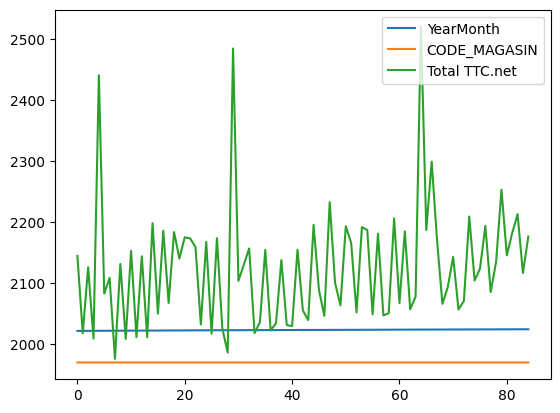

In [5]:
monthly_sales_store.plot()

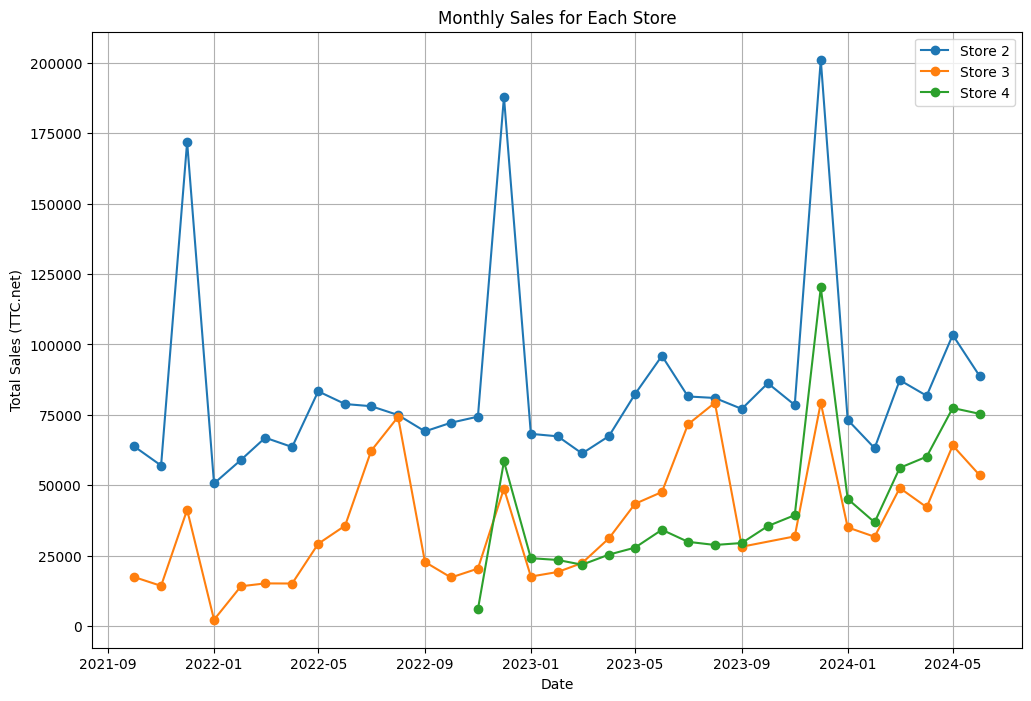

In [6]:
# Get the list of unique stores
stores = monthly_sales_store['CODE_MAGASIN'].unique()

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Plot monthly sales for each store
for store in stores:
    store_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == store]
    plt.plot(store_data['YearMonth'], store_data['Total TTC.net'], marker='o', label=f'Store {store}')

# Add title and labels
plt.title('Monthly Sales for Each Store')
plt.xlabel('Date')
plt.ylabel('Total Sales (TTC.net)')
plt.legend()
plt.grid(True)
plt.show()

Columns for Store 2: ['Total TTC.net', 'First Difference']
ADF Statistic for Store 2: -6.43689491786998
p-value for Store 2: 1.644335350123702e-08
Critical Value 1%: -3.653519805908203
Critical Value 5%: -2.9572185644531253
Critical Value 10%: -2.6175881640625



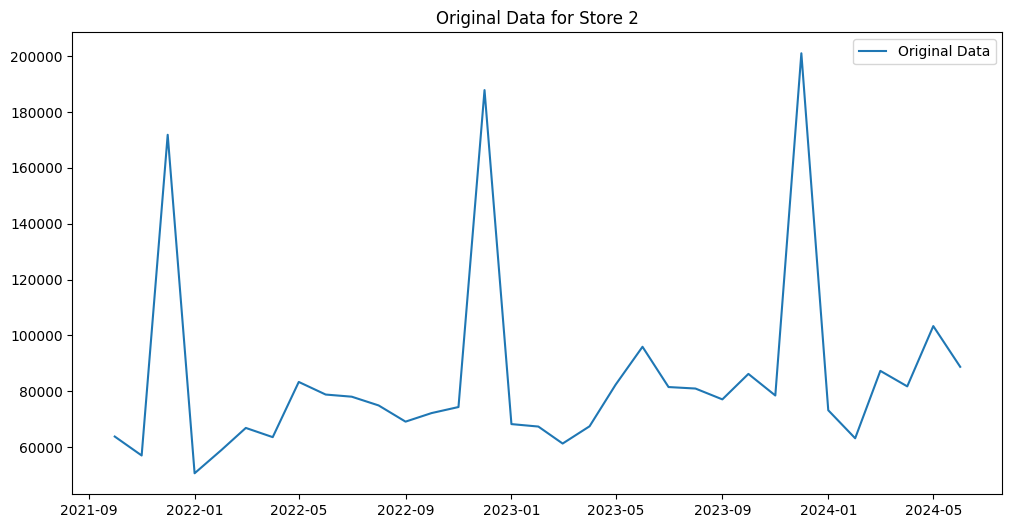

Columns for Store 3: ['Total TTC.net', 'First Difference', 'Seasonal Difference']
ADF Statistic for Store 3: -6.410253073752243
p-value for Store 3: 1.8986109082166673e-08
Critical Value 1%: -3.6790595944893187
Critical Value 5%: -2.9678817237279103
Critical Value 10%: -2.6231583472057074



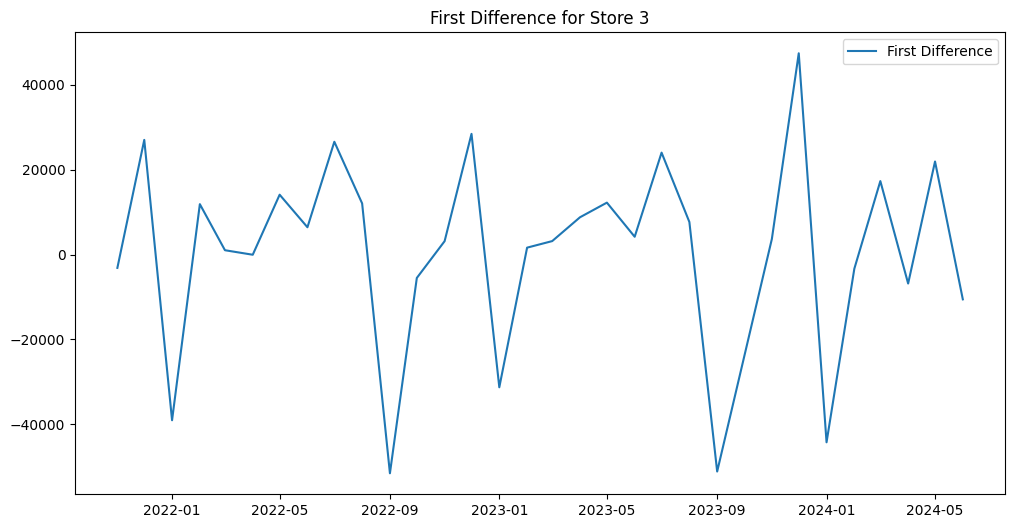

ADF Statistic for Store 4: -6.908165614622216
p-value for Store 4: 1.2318426283819724e-09
Critical Value 1%: -3.859073285322359
Critical Value 5%: -3.0420456927297668
Critical Value 10%: -2.6609064197530863



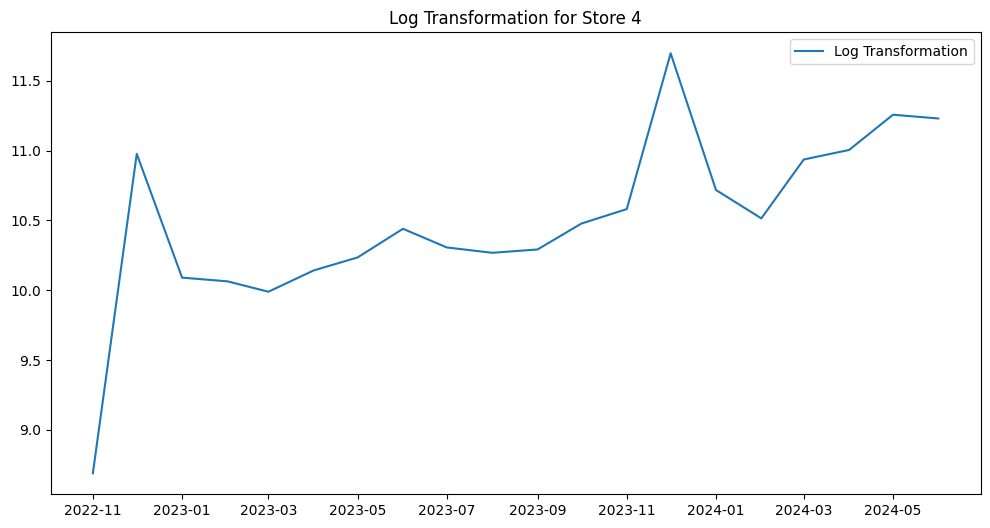

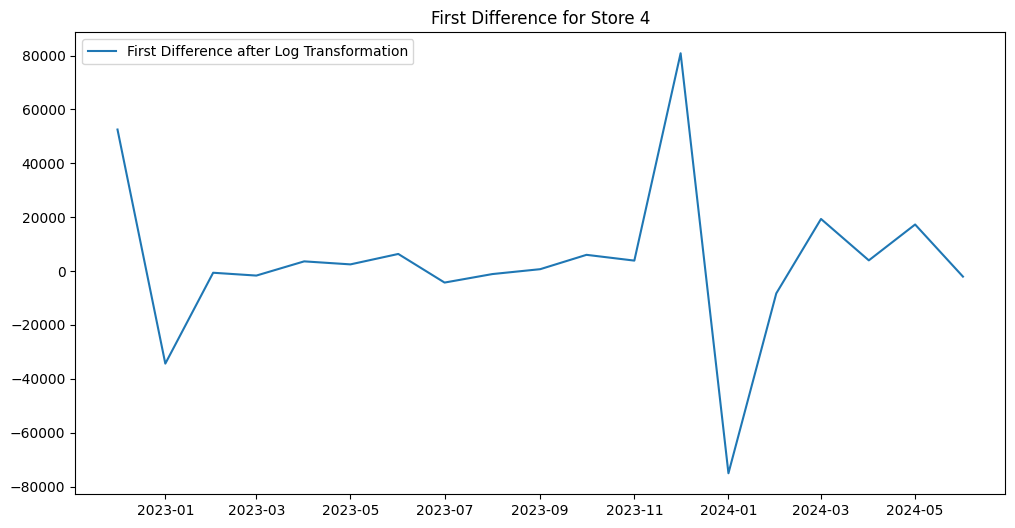

In [7]:
# Function to perform ADF test and print the result
def adf_test(series, store):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for Store {store}: {result[0]}')
    print(f'p-value for Store {store}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    print('')

# Function to apply differencing
def apply_differencing(df, seasonal=False):
    df['First Difference'] = df['Total TTC.net'] - df['Total TTC.net'].shift(1)
    if seasonal:
        df['Seasonal Difference'] = df['Total TTC.net'] - df['Total TTC.net'].shift(12)
    return df

# Function to apply additional differencing
def apply_additional_differencing(df):
    df['Additional Difference'] = df['Seasonal Difference'] - df['Seasonal Difference'].shift(1)
    return df

# Function to apply log transformation
def apply_log_transformation(df):
    df['Log'] = np.log(df['Total TTC.net'])
    return df

# Get the list of unique stores
stores = monthly_sales_store['CODE_MAGASIN'].unique()

# Perform differencing and ADF test for each store
for store in stores:
    store_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == store].set_index('YearMonth')['Total TTC.net'].to_frame()
    
    # Apply differencing or transformation
    if store == 4:
        store_data = apply_log_transformation(store_data)
        
        # Apply differencing after log transformation
        store_data = apply_differencing(store_data)
        
        # Check if log-transformed and differenced series is stationary
        adf_test(store_data['First Difference'].dropna(), store)
        
        plt.figure(figsize=(12, 6))
        plt.plot(store_data['Log'], label='Log Transformation')
        plt.title(f'Log Transformation for Store {store}')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        plt.plot(store_data['First Difference'], label='First Difference after Log Transformation')
        plt.title(f'First Difference for Store {store}')
        plt.legend()
        plt.show()

    else:
        store_data = apply_differencing(store_data, seasonal=(store == 3))
        
        # Print columns to debug
        print(f'Columns for Store {store}: {store_data.columns.tolist()}')
        
        if store == 3:
            if 'First Difference' in store_data.columns:
                adf_test(store_data['First Difference'].dropna(), store)
                plt.figure(figsize=(12, 6))
                plt.plot(store_data['First Difference'], label='First Difference')
                plt.title(f'First Difference for Store {store}')
                plt.legend()
                plt.show()
            else:
                print(f"'First Difference' column not found for Store {store}")
        else:
            adf_test(store_data['Total TTC.net'], store)
            plt.figure(figsize=(12, 6))
            plt.plot(store_data['Total TTC.net'], label='Original Data')
            plt.title(f'Original Data for Store {store}')
            plt.legend()
            plt.show()


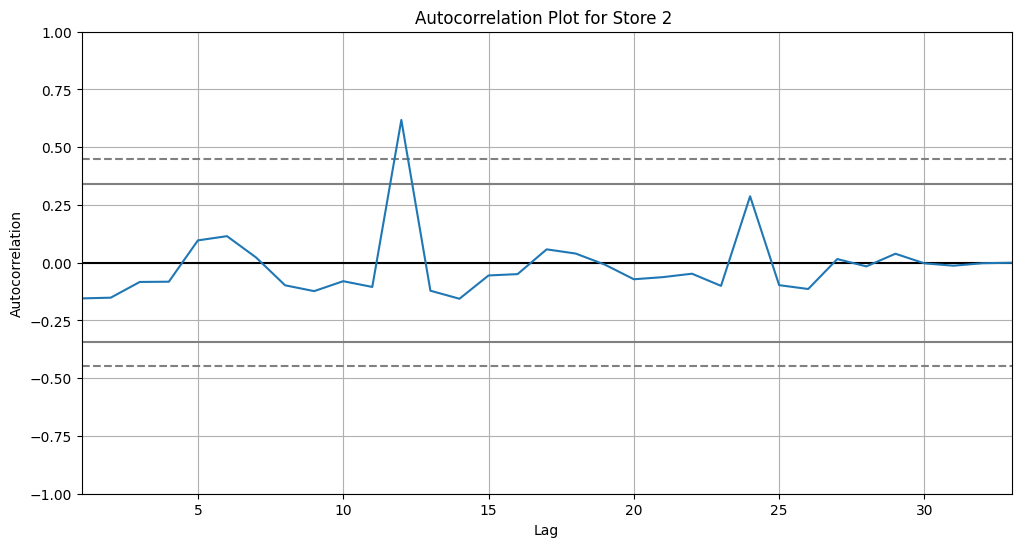

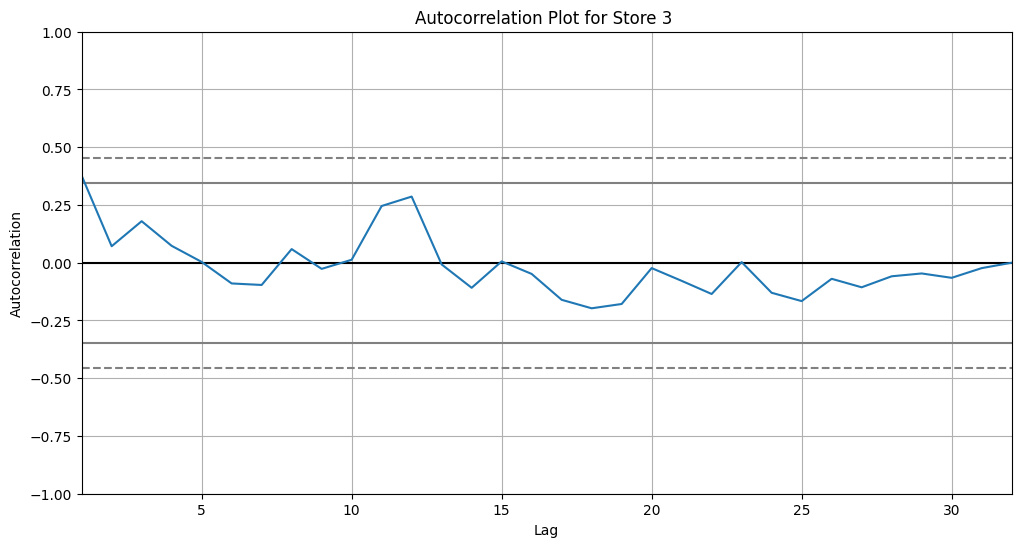

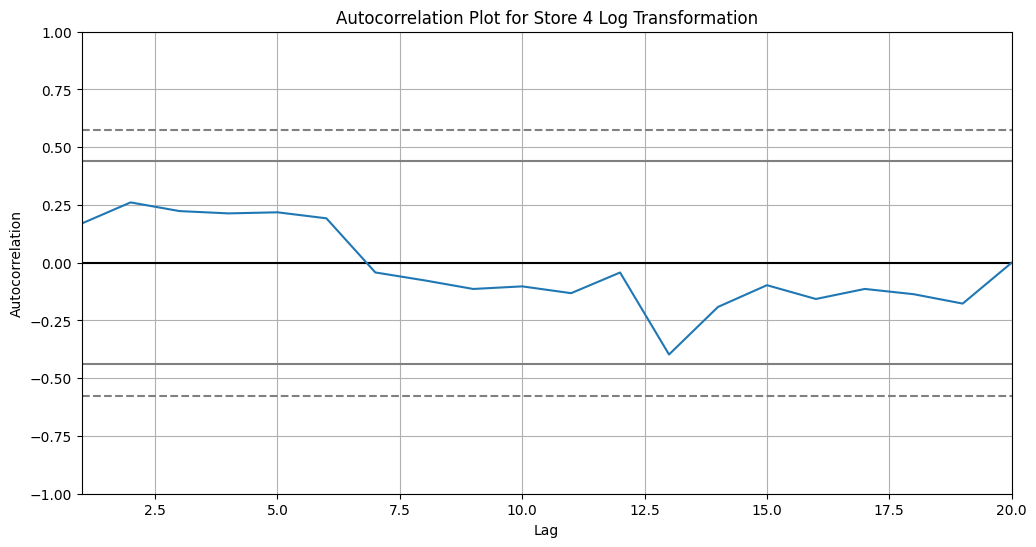

In [8]:
# Function to plot autocorrelation
def plot_autocorrelation(series, store, title_suffix=''):
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(series)
    plt.title(f'Autocorrelation Plot for Store {store} {title_suffix}')
    plt.show()

# Apply log transformation if needed
def get_transformed_data(store, df):
    if store == 4:
        return apply_log_transformation(df)
    return df

# Perform analysis for each store
for store in stores:
    store_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == store].set_index('YearMonth')['Total TTC.net'].to_frame()
    store_data = get_transformed_data(store, store_data)
    
    # Plot autocorrelation
    plot_autocorrelation(store_data['Log'] if store == 4 else store_data['Total TTC.net'], store, 'Log Transformation' if store == 4 else '')

    # Additional plots or analyses can follow here


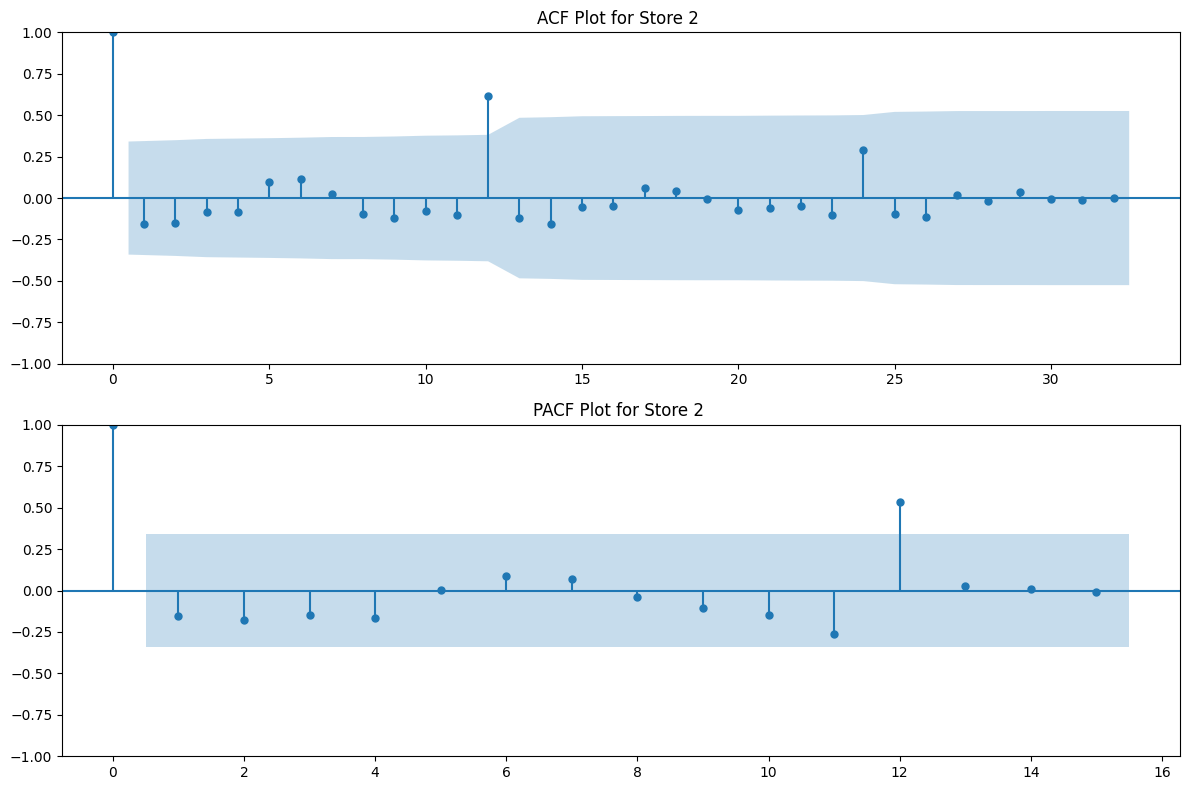

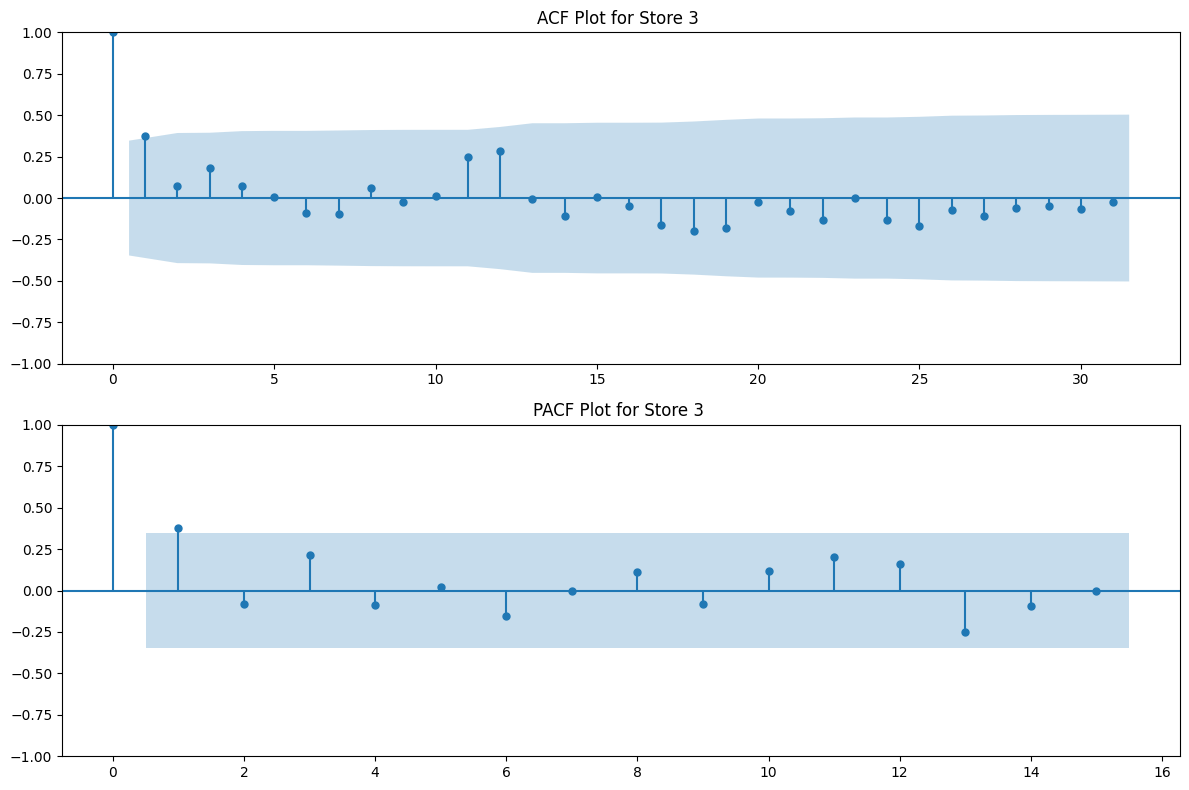

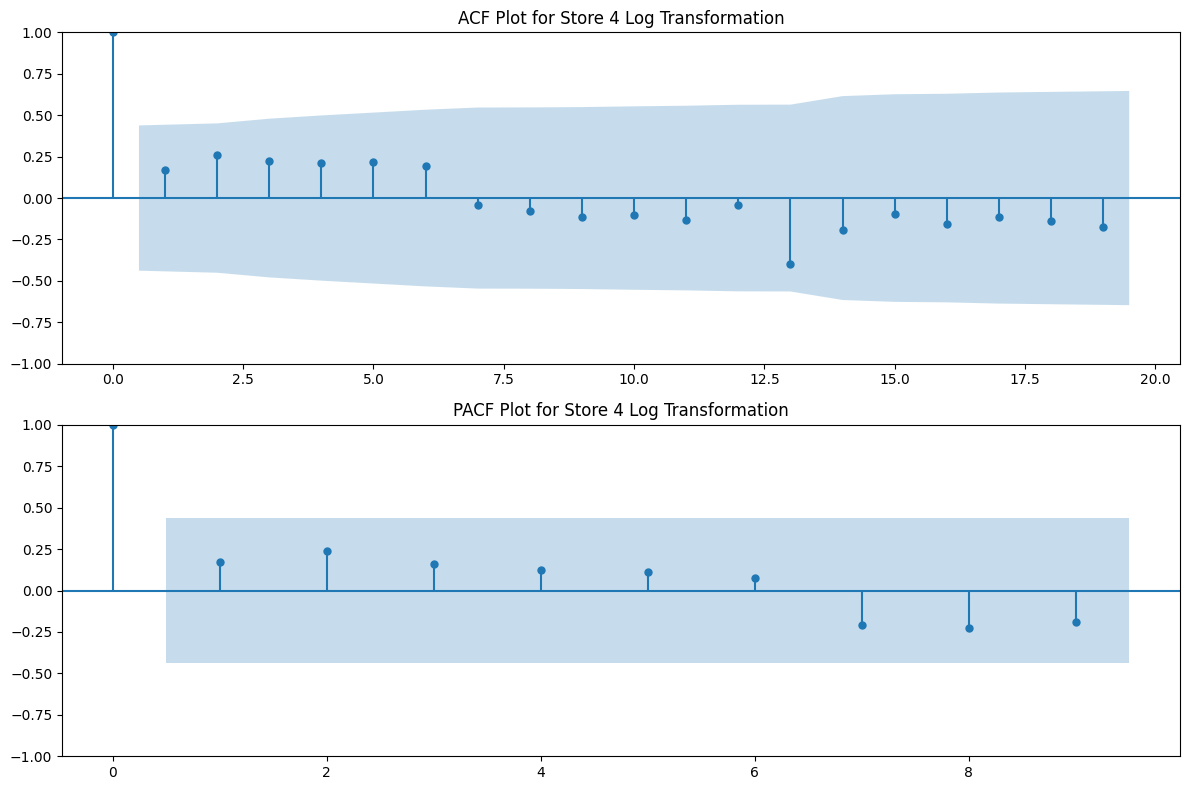

In [9]:
# Function to plot ACF and PACF
def plot_acf_pacf(series, store, title_suffix=''):
    series_clean = series.dropna()
    n_lags_acf = min(len(series_clean) - 1, 40)
    n_lags_pacf = min(len(series_clean) // 2 - 1, 40)  # PACF lags must be < 50% of sample size

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(series_clean, lags=n_lags_acf, ax=ax[0])
    ax[0].set_title(f'ACF Plot for Store {store} {title_suffix}')
    
    plot_pacf(series_clean, lags=n_lags_pacf, ax=ax[1])
    ax[1].set_title(f'PACF Plot for Store {store} {title_suffix}')
    
    plt.tight_layout()
    plt.show()
# Perform ACF and PACF plots for each store
for store in stores:
    store_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == store].set_index('YearMonth')['Total TTC.net'].to_frame()
    store_data = get_transformed_data(store, store_data)
    
    series = store_data['Log'].dropna() if store == 4 else store_data['Total TTC.net'].dropna()
    
    # Plot ACF and PACF
    plot_acf_pacf(series, store, 'Log Transformation' if store == 4 else '')

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to fit and plot ARIMA model
def fit_arima_model(series, store, order):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
    plt.title(f'ARIMA Model Fit for Store {store}')
    plt.legend()
    plt.show()
    
    return model_fit

                               SARIMAX Results                                
Dep. Variable:          Total TTC.net   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -383.268
Date:                Sat, 17 Aug 2024   AIC                            772.537
Time:                        22:43:05   BIC                            776.934
Sample:                    10-01-2021   HQIC                           773.994
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0882      0.806     -0.109      0.913      -1.668       1.491
ma.L1         -0.9303      0.191     -4.863      0.000      -1.305      -0.555
sigma2      1.432e+09    7.3e-10   1.96e+18      0.0

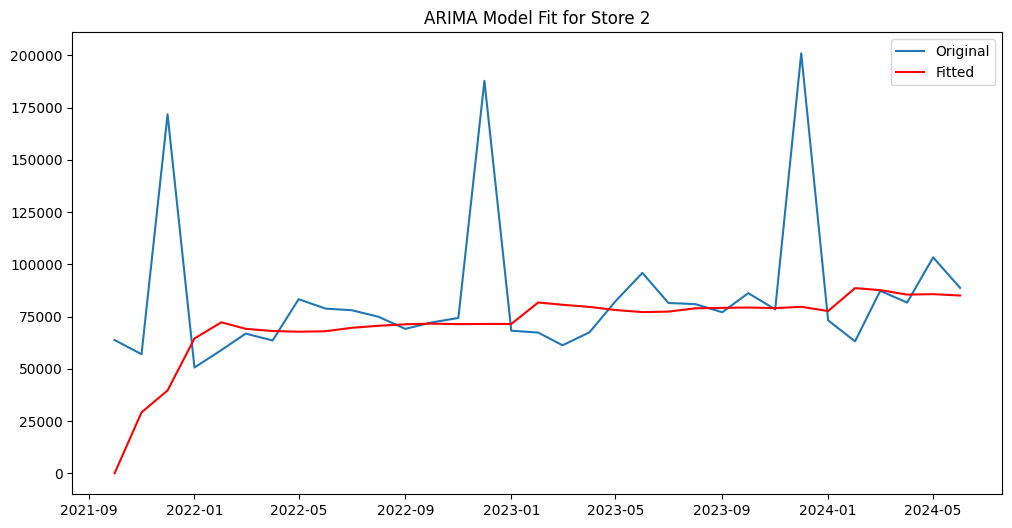

In [11]:
# Fit ARIMA model for Store 2
store_2_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 2].set_index('YearMonth')['Total TTC.net'].to_frame()
arima_order = (1,1,1)  # Define p, d, q based on analysis
fit_arima_model(store_2_data['Total TTC.net'], 2, arima_order)


                                 SARIMAX Results                                 
Dep. Variable:     Additional Difference   No. Observations:                   19
Model:                    ARIMA(1, 1, 1)   Log Likelihood                -205.767
Date:                   Sat, 17 Aug 2024   AIC                            417.535
Time:                           22:43:06   BIC                            420.206
Sample:                                0   HQIC                           417.903
                                    - 19                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5477      0.345     -1.588      0.112      -1.224       0.128
ma.L1         -0.9197      0.430     -2.137      0.033      -1.763      -0.076
sigma2      7.085e+08   5.19

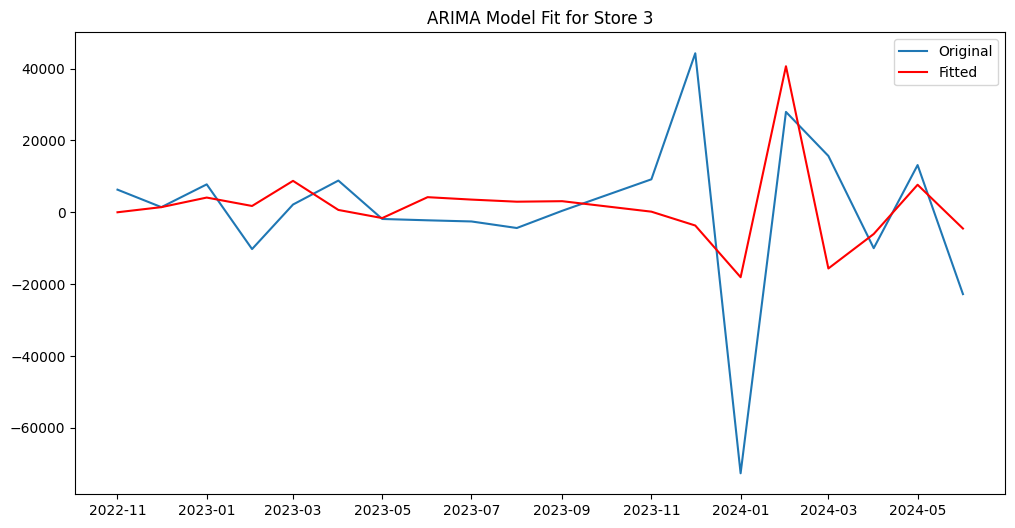

In [12]:
# Filter data for Store 3 and set up the series
store_3_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 3].set_index('YearMonth')['Total TTC.net'].to_frame()

# Apply differencing including seasonal differencing
store_3_data = apply_differencing(store_3_data, seasonal=True)
store_3_data = apply_additional_differencing(store_3_data)
# Define ARIMA order (p, d, q) based on your analysis or experiment
arima_order = (1, 1, 1)  # Adjust these orders as needed

# Fit ARIMA model for Store 3
fit_arima_model(store_3_data['Additional Difference'].dropna(), 3, arima_order)


                               SARIMAX Results                                
Dep. Variable:                    Log   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -15.740
Date:                Sat, 17 Aug 2024   AIC                             37.480
Time:                        22:43:07   BIC                             40.314
Sample:                    11-01-2022   HQIC                            37.960
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3813      0.354     -1.077      0.281      -1.075       0.312
ma.L1         -0.5602      0.384     -1.460      0.144      -1.312       0.192
sigma2         0.2924      0.083      3.543      0.0

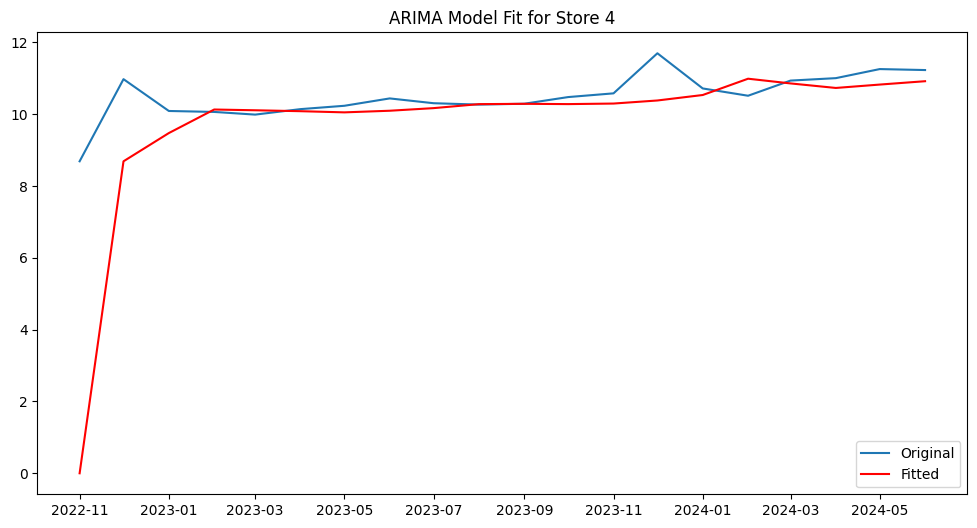

In [13]:
# Filter data for Store 4 and set up the series
store_4_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 4].set_index('YearMonth')['Total TTC.net'].to_frame()

# Apply log transformation
store_4_data = apply_log_transformation(store_4_data)
# Define ARIMA order (p, d, q) based on your analysis or experiment
arima_order = (1, 1, 1)  # Adjust these orders as needed

# Fit ARIMA model for Store 4
fit_arima_model(store_4_data['Log'].dropna(), 4, arima_order)


In [14]:
# Function to fit and plot SARIMA model
def fit_sarima_model(series, store, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
    plt.title(f'SARIMA Model Fit for Store {store}')
    plt.legend()
    plt.show()
    
    return model_fit

                                     SARIMAX Results                                      
Dep. Variable:                   First Difference   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -205.393
Date:                            Sat, 17 Aug 2024   AIC                            420.785
Time:                                    22:43:08   BIC                            425.508
Sample:                                11-01-2021   HQIC                           421.585
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5489      0.870     -0.631      0.528      -2.253       1.155
ma.L1         -0.9562      0.812   

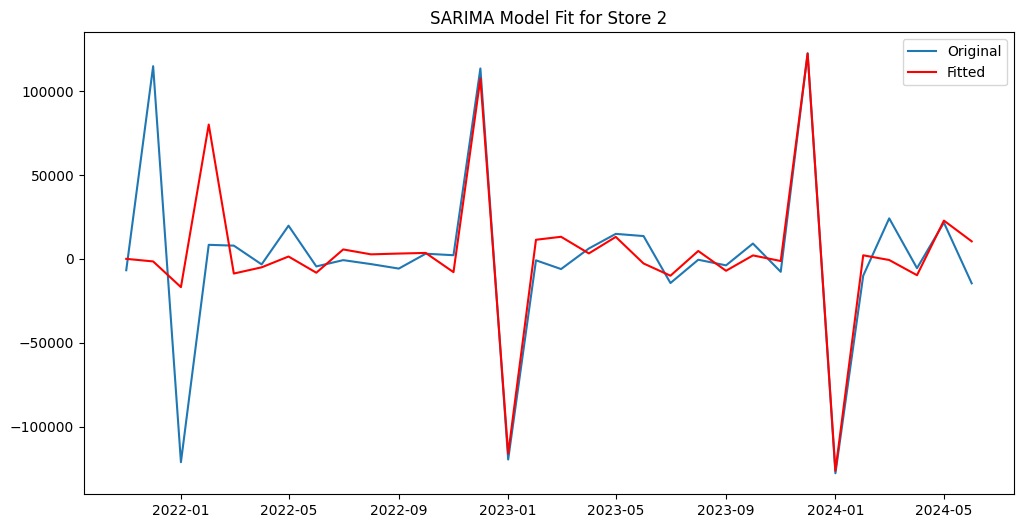

In [15]:
# Filter data for Store 2 and set up the series
store_2_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 2].set_index('YearMonth')['Total TTC.net'].to_frame()

# Apply differencing if not already done
store_2_data = apply_differencing(store_2_data)
# Define SARIMA order and seasonal order
sarima_order = (1, 1, 1)  # Adjust these orders if needed
seasonal_order = (1, 1, 1, 12)  # Seasonal order with 12 periods

# Fit SARIMA model for Store 2
fit_sarima_model(store_2_data['First Difference'].dropna(), 2, sarima_order, seasonal_order)


                                     SARIMAX Results                                      
Dep. Variable:                      Total TTC.net   No. Observations:                   33
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -214.610
Date:                            Sat, 17 Aug 2024   AIC                            439.220
Time:                                    22:43:09   BIC                            444.199
Sample:                                10-01-2021   HQIC                           440.192
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1558      1.766     -0.088      0.930      -3.618       3.306
ma.L1         -0.1548      1.696   

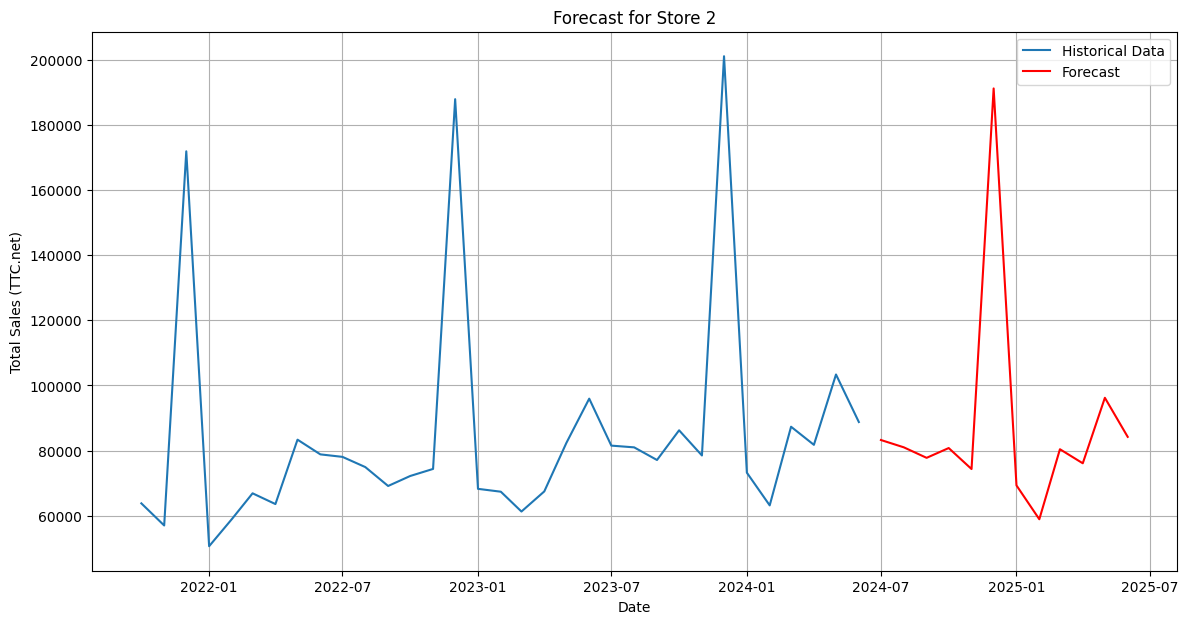

In [16]:
# Filter data for Store 2 and set up the series
store_2_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 2].set_index('YearMonth')['Total TTC.net'].to_frame()

# Apply differencing if needed (assuming you have this function)
store_2_data = apply_differencing(store_2_data, seasonal=True)  # Adjust function as needed

# Define SARIMA order and seasonal order
sarima_order = (1, 1, 1)  # Adjust these orders if needed
seasonal_order = (1, 1, 1, 12)  # Seasonal order with 12 periods

# Fit SARIMA model
def fit_sarima_model(series, store, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    return model_fit

model_fit = fit_sarima_model(store_2_data['Total TTC.net'].dropna(), 2, sarima_order, seasonal_order)

# Forecast future values for the next 12 months
steps = 12
future_dates = [store_2_data.index[-1] + DateOffset(months=x) for x in range(1, steps + 1)]
future_df = pd.DataFrame(index=future_dates, columns=['forecast'])

# Generate forecast
forecast = model_fit.get_forecast(steps=steps).predicted_mean
future_df['forecast'] = forecast

# Combine historical and future data
combined_df = pd.concat([store_2_data, future_df])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(store_2_data.index, store_2_data['Total TTC.net'], label='Historical Data')
plt.plot(future_df.index, future_df['forecast'], color='red', label='Forecast')
plt.title('Forecast for Store 2')
plt.xlabel('Date')
plt.ylabel('Total Sales (TTC.net)')
plt.legend()
plt.grid(True)
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:               Additional Difference   No. Observations:                   19
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -70.438
Date:                             Sat, 17 Aug 2024   AIC                            148.877
Time:                                     22:44:48   BIC                            148.044
Sample:                                          0   HQIC                           145.542
                                              - 19                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5396      1.214     -0.444      0.657      -2.920       1.841
ma.L1         -1.0000      

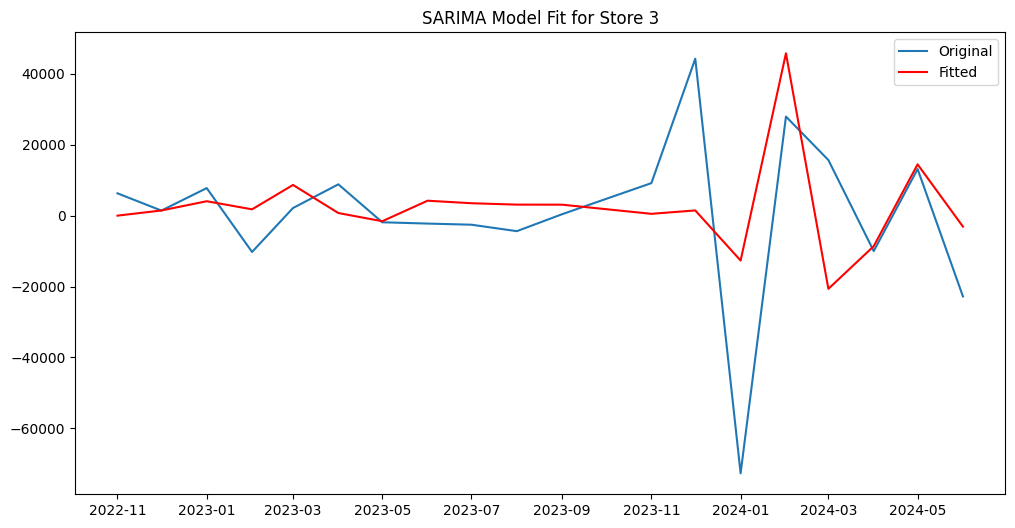

Forecast values:
 19    10466.621284
20    -7848.446789
21      630.688915
22    -1283.883112
23     7690.664868
24    32591.950702
25   -49871.050089
26    21990.321326
27     8250.223311
28    -6131.403500
29    12133.137081
30   -16255.337468
31     6927.479307
32    -6000.728411
33     -605.951368
34     -512.817659
35     8400.369818
36    36354.005479
37   -56438.331067
38    24037.121705
39    10742.827141
40    -7025.427819
41    12699.108743
42   -17948.053106
Name: predicted_mean, dtype: float64


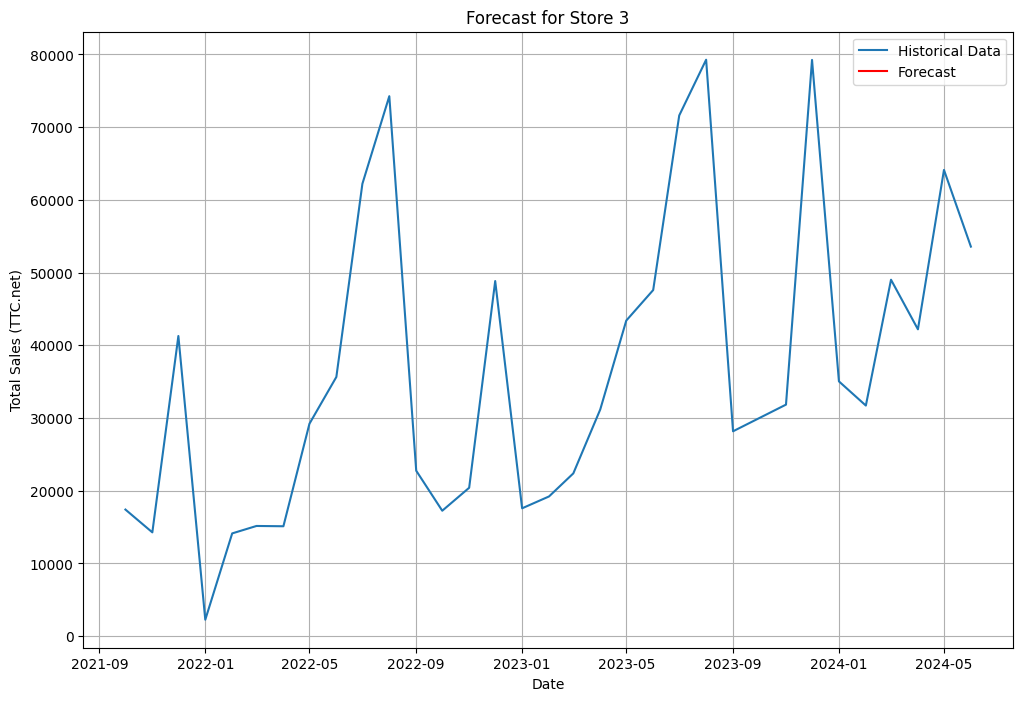

In [19]:
# Define function to fit SARIMA model
def fit_sarima_model(series, store, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
    plt.title(f'SARIMA Model Fit for Store {store}')
    plt.legend()
    plt.show()
    
    return model_fit

# Filter data for Store 3 and set up the series
store_3_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 3].set_index('YearMonth')['Total TTC.net'].to_frame()

# Apply differencing including seasonal differencing
store_3_data_diff = apply_differencing(store_3_data, seasonal=True)
store_3_data_diff = apply_additional_differencing(store_3_data_diff)

# Define SARIMA order and seasonal order
sarima_order = (1, 1, 1)  # Adjust these orders if needed
seasonal_order = (1, 1, 0, 12)  # Seasonal order with 12 periods

# Fit SARIMA model
model_fit = fit_sarima_model(store_3_data_diff['Additional Difference'].dropna(), 3, sarima_order, seasonal_order)

# Forecast future values
steps = 24
future_dates = [store_3_data.index[-1] + DateOffset(months=x) for x in range(1, steps + 1)]
future_df = pd.DataFrame(index=future_dates, columns=['forecast'])

# Generate forecast
forecast = model_fit.get_forecast(steps=steps).predicted_mean
print("Forecast values:\n", forecast)  # Debugging: Print forecast values

# Reverse differencing
# For first differencing
forecast_cumsum = forecast.cumsum()
last_observed_value = store_3_data['Total TTC.net'].iloc[-1]
forecast_inverted = last_observed_value + forecast_cumsum

# Ensure future dates are correctly assigned to forecast
future_df['forecast'] = forecast_inverted

# Combine historical and future data
combined_df = pd.concat([store_3_data, future_df])

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(store_3_data.index, store_3_data['Total TTC.net'], label='Historical Data')
plt.plot(future_df.index, future_df['forecast'], color='red', label='Forecast')
plt.title('Forecast for Store 3')
plt.xlabel('Date')
plt.ylabel('Total Sales (TTC.net)')
plt.legend()
plt.grid(True)
plt.show()


                                      SARIMAX Results                                      
Dep. Variable:                                 Log   No. Observations:                   20
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                  -4.493
Date:                             Sat, 17 Aug 2024   AIC                             16.986
Time:                                     22:45:06   BIC                             16.770
Sample:                                 11-01-2022   HQIC                            14.312
                                      - 06-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9945    139.791     -0.007      0.994    -274.979     272.990
ma.L1          0.9692     7

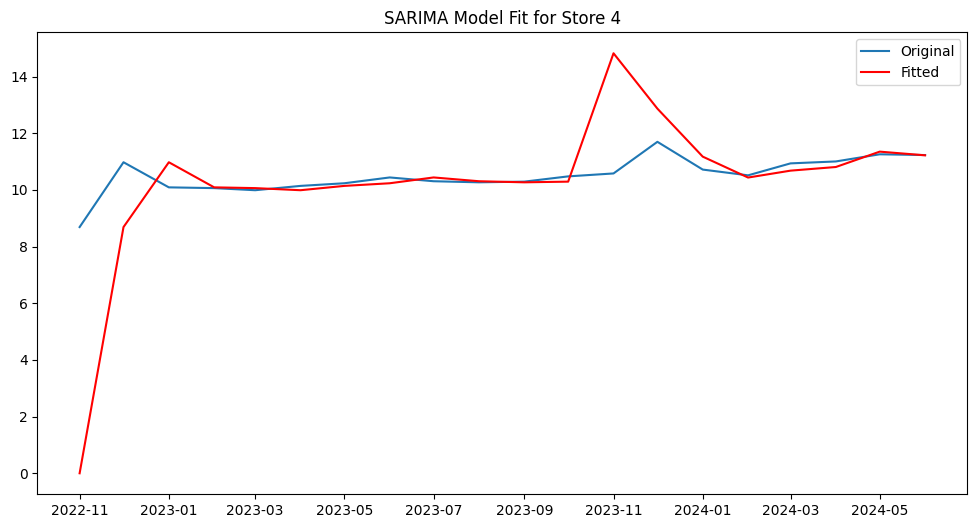

Forecast values (log scale):
 2024-07-01    11.336343
2024-08-01    11.058161
2024-09-01    11.321723
2024-10-01    11.267780
2024-11-01    11.610798
2024-12-01    11.812307
2025-01-01    10.827798
2025-02-01    10.433966
2025-03-01    11.278533
2025-04-01    11.223585
2025-05-01    11.653394
2025-06-01    11.396573
2025-07-01    11.738277
2025-08-01    11.225320
2025-09-01    11.723194
2025-10-01    11.435396
2025-11-01    12.011817
2025-12-01    11.489565
2026-01-01    10.560074
2026-02-01     9.969240
2026-03-01    11.179122
2026-04-01    10.976958
2026-05-01    11.593053
2026-06-01    11.112112
Freq: MS, Name: predicted_mean, dtype: float64


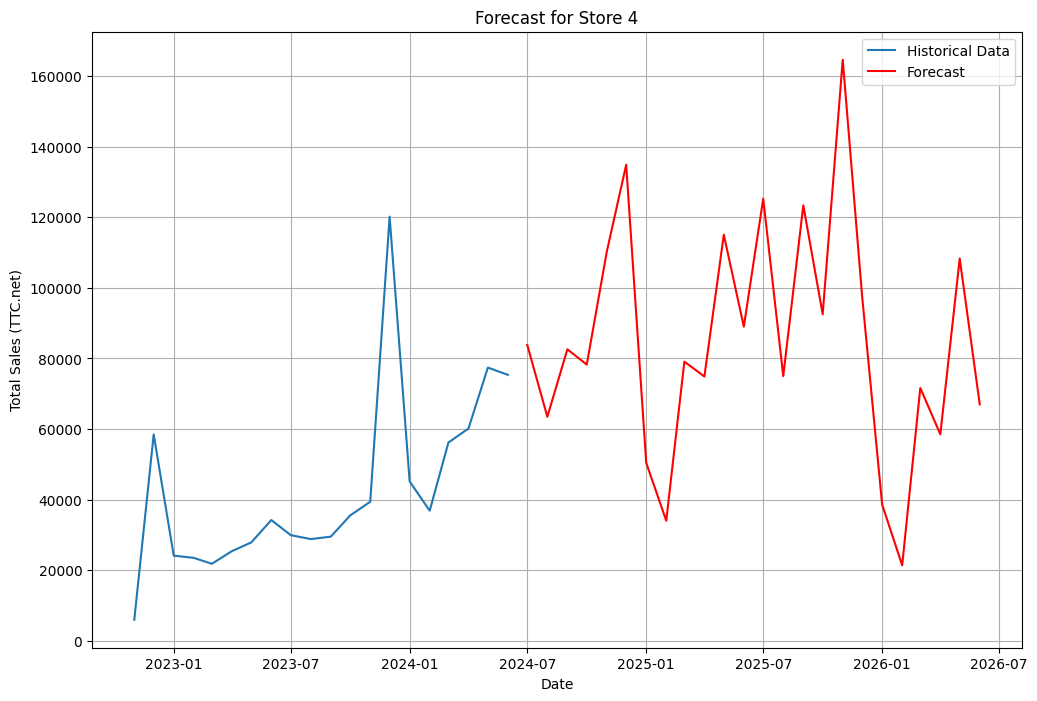

In [20]:
# Function to apply log transformation
def apply_log_transformation(df):
    df['Log'] = np.log(df['Total TTC.net'])
    return df

# Define function to fit SARIMA model
def fit_sarima_model(series, store, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
    plt.title(f'SARIMA Model Fit for Store {store}')
    plt.legend()
    plt.show()
    
    return model_fit

# Filter data for Store 4 and set up the series
store_4_data = monthly_sales_store[monthly_sales_store['CODE_MAGASIN'] == 4].set_index('YearMonth')['Total TTC.net'].to_frame()

# Apply log transformation
store_4_data = apply_log_transformation(store_4_data)

# Define SARIMA order and seasonal order
sarima_order = (1, 1, 1)  # Adjust these orders if needed
seasonal_order = (1, 1, 0, 12)  # Seasonal order with 12 periods

# Fit SARIMA model
model_fit = fit_sarima_model(store_4_data['Log'].dropna(), 4, sarima_order, seasonal_order)

# Forecast future values
steps = 24
future_dates = [store_4_data.index[-1] + DateOffset(months=x) for x in range(1, steps + 1)]
future_df = pd.DataFrame(index=future_dates, columns=['forecast'])

# Generate forecast
forecast = model_fit.get_forecast(steps=steps).predicted_mean
print("Forecast values (log scale):\n", forecast)  # Debugging: Print forecast values in log scale

# Reverse log transformation
forecast_exp = np.exp(forecast)  # Convert from log scale to original scale

# Ensure future dates are correctly assigned to forecast
future_df['forecast'] = forecast_exp

# Combine historical and future data
combined_df = pd.concat([store_4_data, future_df])

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(store_4_data.index, store_4_data['Total TTC.net'], label='Historical Data')
plt.plot(future_df.index, future_df['forecast'], color='red', label='Forecast')
plt.title('Forecast for Store 4')
plt.xlabel('Date')
plt.ylabel('Total Sales (TTC.net)')
plt.legend()
plt.grid(True)
plt.show()
